# Предсказание стоимости авто

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# 1. Подготовка данных

### 1.1 Общие сведения по датасету

Загружаем необходимые библиотеки и модули

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings(action='ignore')

sns.set()

Загружаем датасет:

In [2]:
df = pd.read_csv('datasets/autos.csv')

In [3]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


In [5]:
start_size = df.shape

Данные имеют пропуски. Посмотрим, в каких столбцах:

In [6]:
def show_nan(df):
    for i in df.columns:
        if df[i].isnull().sum() > 0:
            print(f'В признаке {i} {df[i].isnull().sum()} пропусков')

In [7]:
show_nan(df)

В признаке VehicleType 37490 пропусков
В признаке Gearbox 19833 пропусков
В признаке Model 19705 пропусков
В признаке FuelType 32895 пропусков
В признаке NotRepaired 71154 пропусков


### 1.2 Построение диаграмм и графиков

Сразу удалим те признаки, которые не нужны при обучении:
- DateCrawled — дата скачивания анкеты из базы
- DateCreated — дата создания анкеты
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя
- RegistrationMonth — месяц регистрации автомобиля

Также удалим признак - NumberOfPictures — количество фотографий автомобиля, так как все значения заполнены 0

In [8]:
df['NumberOfPictures'].value_counts()

0    354369
Name: NumberOfPictures, dtype: int64

In [9]:
df.drop(['DateCrawled', 'DateCreated', 'PostalCode', 'LastSeen', 'RegistrationMonth', 'NumberOfPictures'], axis=1, inplace=True)

In [10]:
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


Можно предположить, что пропуски появились в результате некорректно заполненных анкет.

Построим гистограммы признаков RegistrationYear, Power и Kilometer

**Признаки RegistrationYear**

In [11]:
def hist_and_box(data, colname):
    fig, ax = plt.subplots(2, 1, figsize=(15, 11))
    ax[0].hist(df[colname], bins=100)
    ax[1].boxplot(data[colname], vert=False);

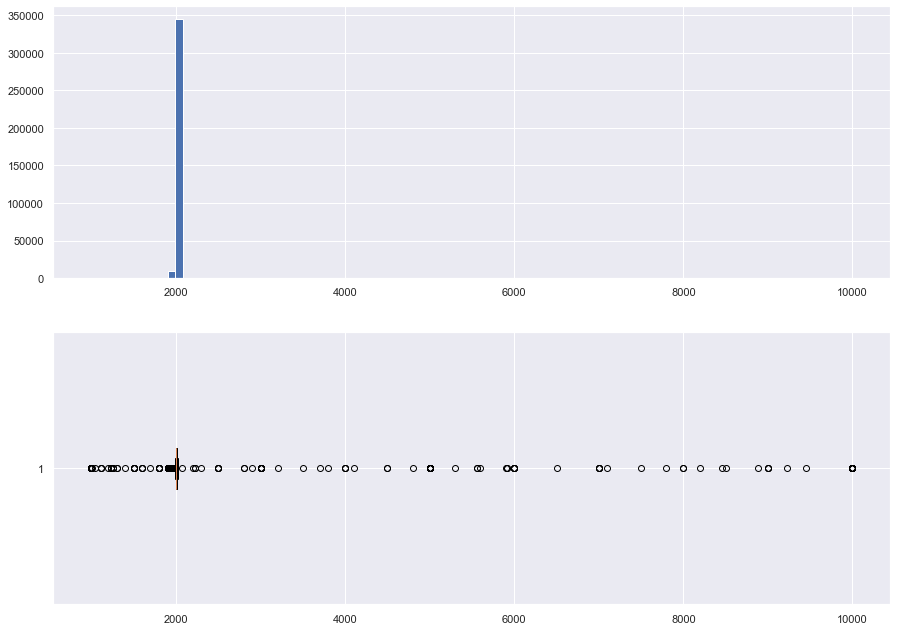

In [12]:
hist_and_box(df, 'RegistrationYear')

Удалим выбросы, которые есть после 2019 года

In [13]:
df = df[df['RegistrationYear'] < 2020]

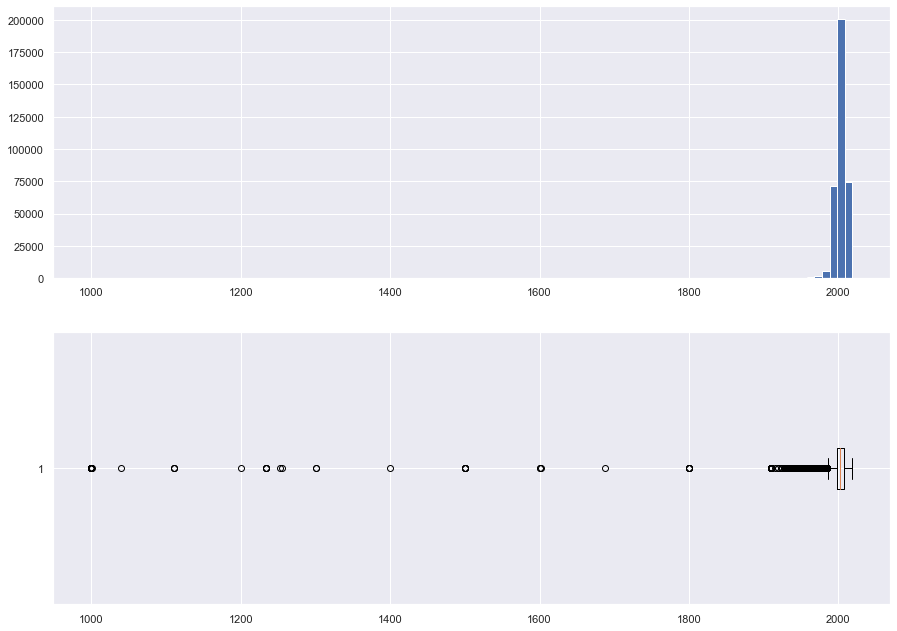

In [14]:
hist_and_box(df, 'RegistrationYear')

Рассмотрим годы регистрации, более 1950:

In [15]:
df = df[df['RegistrationYear'] > 1950]

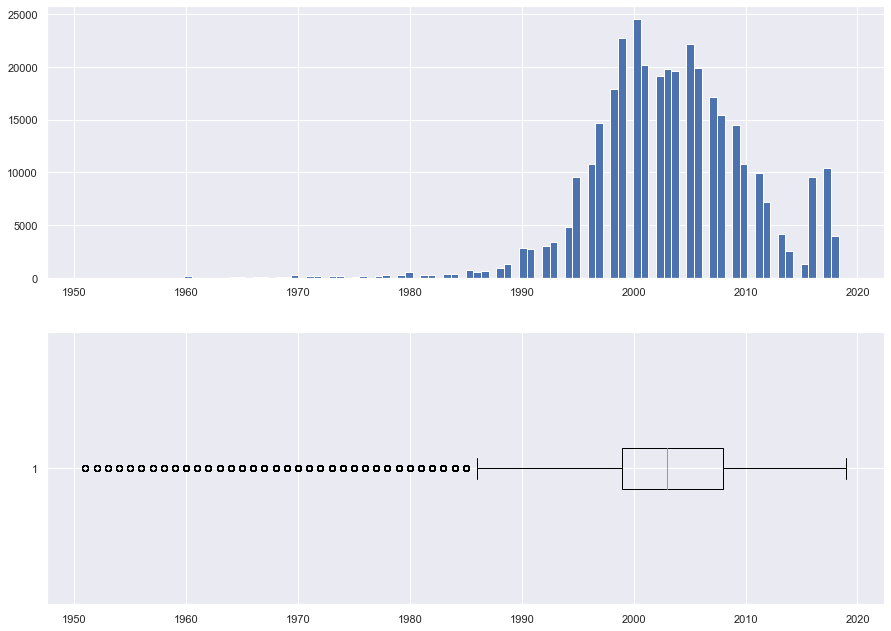

In [16]:
hist_and_box(df, 'RegistrationYear')

Распределение становится похожим на нормальное. Удалим объекты с регистрацией до 1987

In [17]:
df = df[df['RegistrationYear'] > 1986]

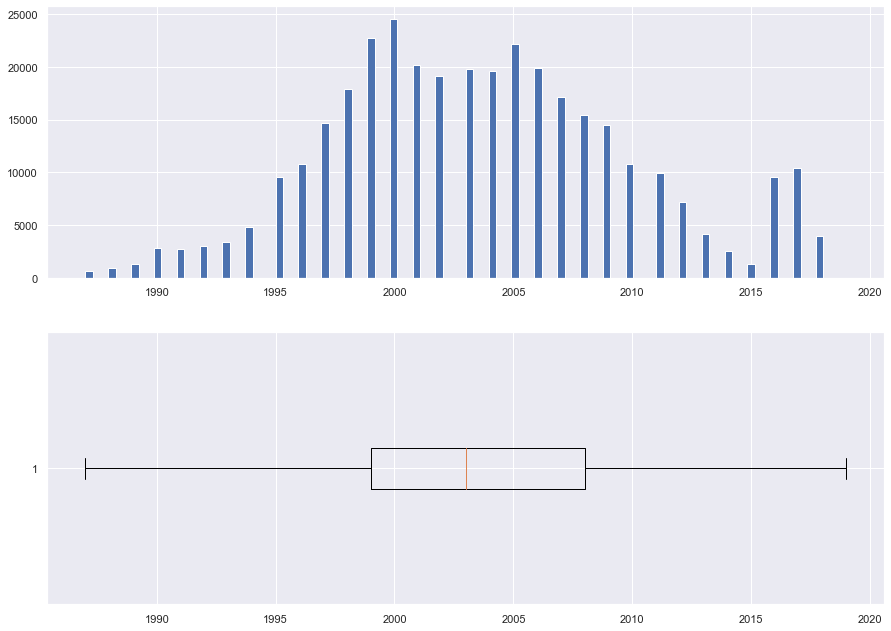

In [18]:
hist_and_box(df, 'RegistrationYear')

**Признаки Kilometer**

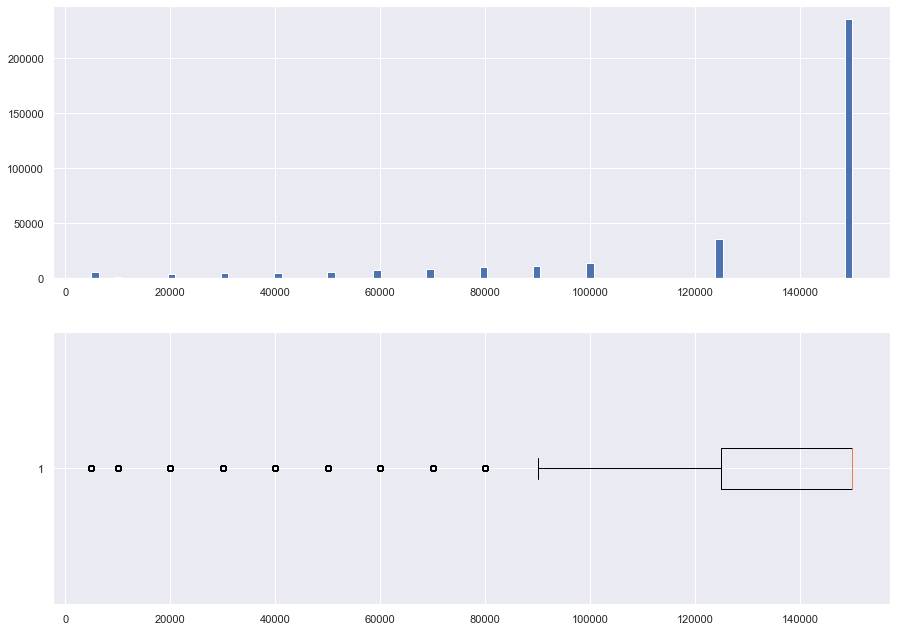

In [19]:
hist_and_box(df, 'Kilometer')

Не будем обрабатывать значения, ведь пробег может быть и 0, если автомобиль новый.

**Признаки Power**

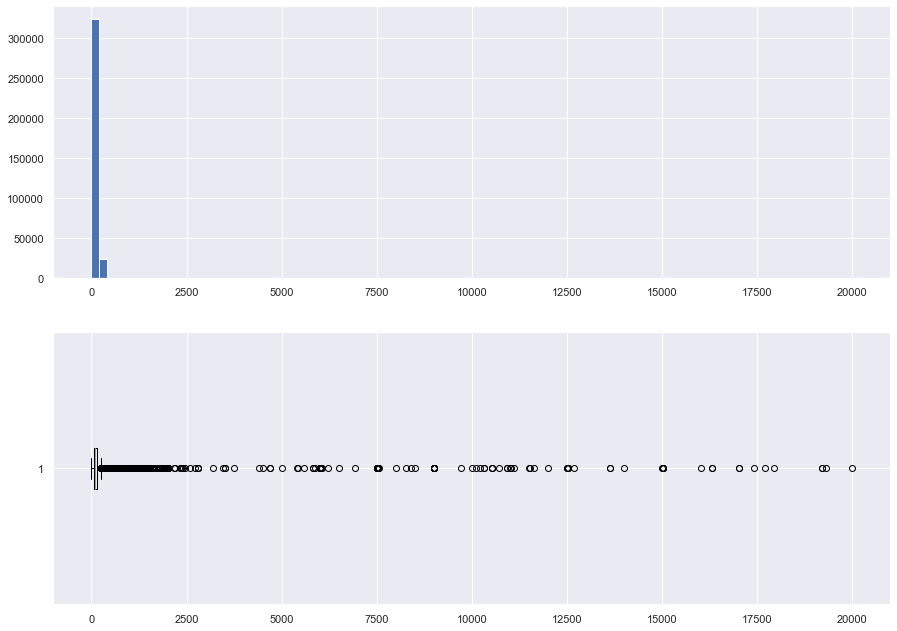

In [20]:
hist_and_box(df, 'Power')

Уберем все автомобили, мощность которых более 1000


In [21]:
df = df[df['Power'] < 1000]

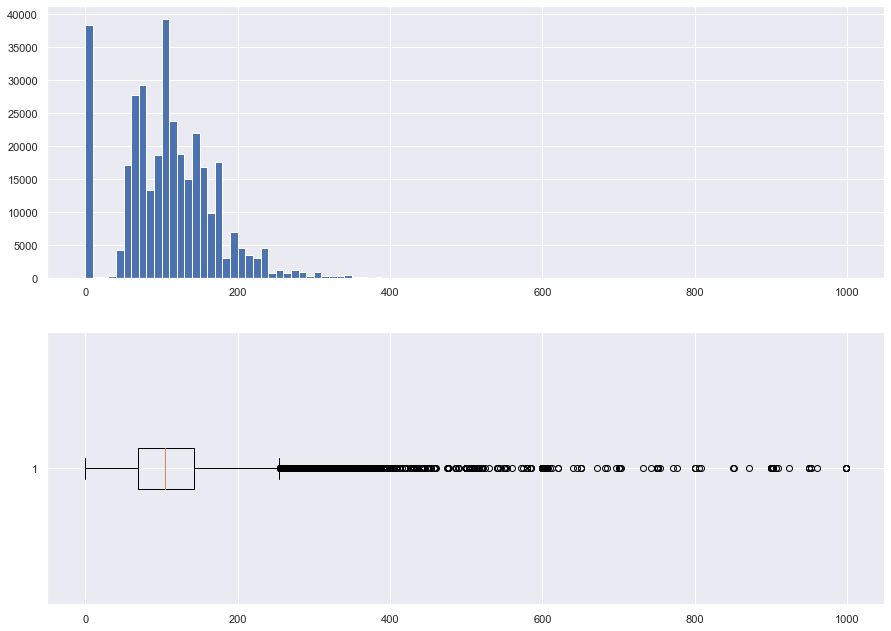

In [22]:
hist_and_box(df, 'Power')

Отбросим все значения больше 250:

In [23]:
df = df[df['Power'] < 250]

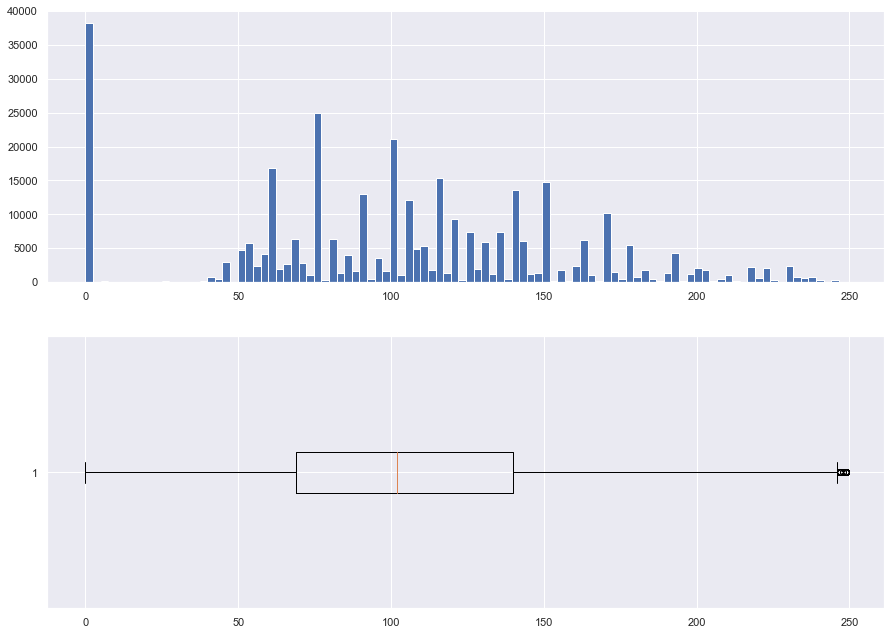

In [24]:
hist_and_box(df, 'Power')

Очень много объектов имеют значения менее 40. Уберем и их.

In [25]:
df = df[df['Power'] > 40]

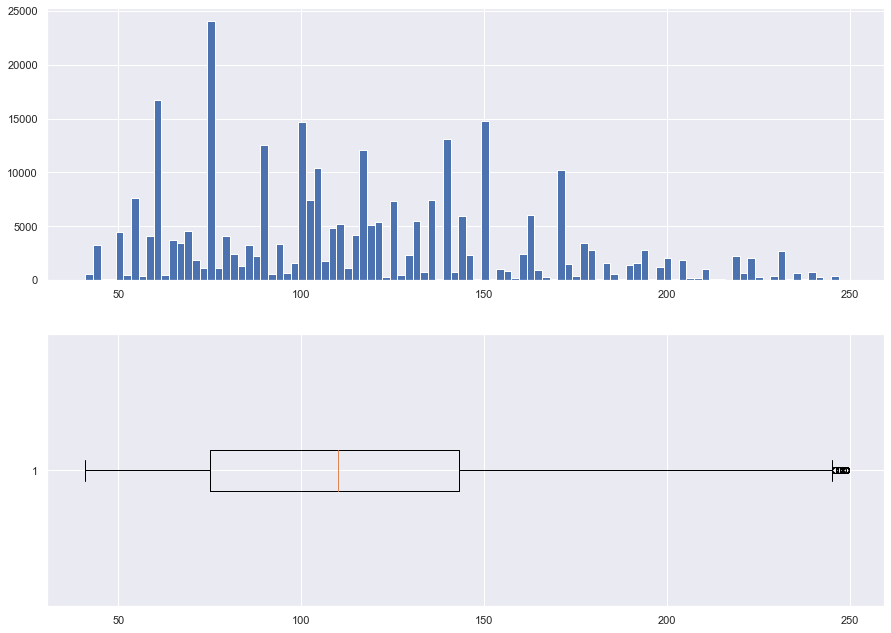

In [26]:
hist_and_box(df, 'Power')

Посмотрим, сколько всего объектов уже удалено:

In [27]:
print(f'Удалено объектов с аномальными значениями - {start_size[0] - df.shape[0]}')

Удалено объектов с аномальными значениями - 54163


**Признак Price**

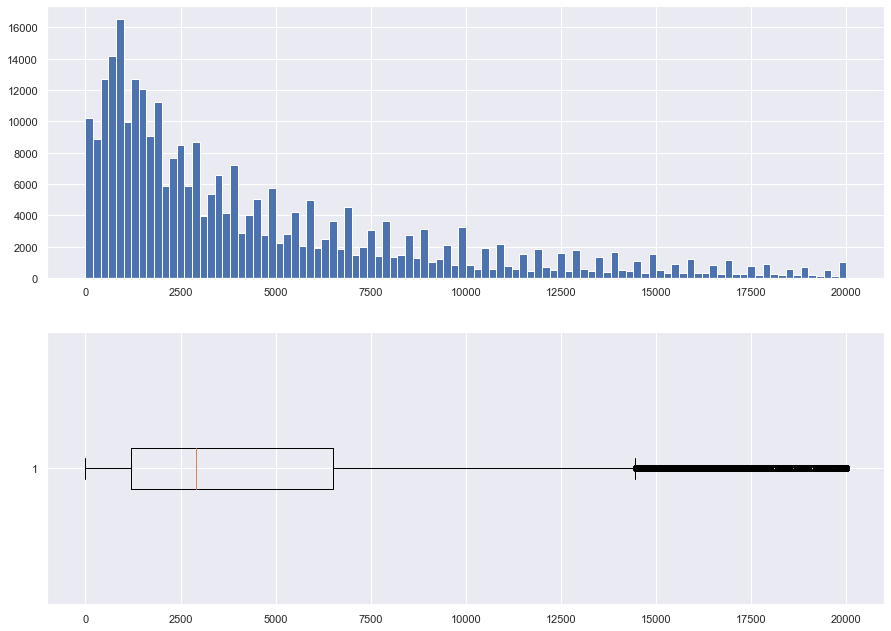

In [28]:
hist_and_box(df, 'Price')

In [29]:
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes


In [30]:
df.corr()['Price']

Price               1.000000
RegistrationYear    0.526519
Power               0.485657
Kilometer          -0.404551
Name: Price, dtype: float64

### Вывод:

Обработаны и удалены аномальные значения в RegistrationYear и Power. Возникновение этих аномалий возможно из-за ошибок при проведения анкетирования или некорректного занесения данных в базу данных. 

### 1.3 Обработка пропусков

Посмотрим еще раз, в каких признаках есть пропуски:

In [31]:
show_nan(df)

В признаке VehicleType 21968 пропусков
В признаке Gearbox 6113 пропусков
В признаке Model 11823 пропусков
В признаке FuelType 20195 пропусков
В признаке NotRepaired 47262 пропусков


In [32]:
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes


**Признак VehicleType**

In [33]:
df['VehicleType'].value_counts()

sedan          79746
small          70270
wagon          59061
bus            26225
convertible    17796
coupe          12907
suv             9891
other           2342
Name: VehicleType, dtype: int64

Пропуск мог появиться, если анкетируемый не смог определиться с выбором. Для этого есть категория other. Заполним пропуски значением other

In [34]:
df['VehicleType'] = df['VehicleType'].fillna('other')

**Признак Gearbox**

In [35]:
df['Gearbox'].value_counts()

manual    239623
auto       54470
Name: Gearbox, dtype: int64

Одна и таже марка автомобиля может быть как с автоматической так и с механической КП. Заполним значением manual отсутствующие признаки, так как таких автомобилей в 5 раз больше.

In [36]:
df['Gearbox'] = df['Gearbox'].fillna('manual')

**Признак Model**

Если не указана модель - укажем other

In [37]:
df['Model'].value_counts()

golf          26153
other         17978
3er           17757
polo          11327
corsa         10685
              ...  
rangerover        3
cayenne           2
911               2
601               1
serie_2           1
Name: Model, Length: 247, dtype: int64

In [38]:
df['Model'] = df['Model'].fillna('other')

**Признак FuelType**

In [39]:
df['FuelType'].value_counts()

petrol      185889
gasoline     89012
lpg           4311
cng            502
hybrid         203
other           56
electric        38
Name: FuelType, dtype: int64

Также заполним пропуски значением other:

In [40]:
df['FuelType'] = df['FuelType'].fillna('other')

**Признак NotRepaired**

In [41]:
df['NotRepaired'].value_counts()

no     222937
yes     30007
Name: NotRepaired, dtype: int64

Как видно, подавляющее большенство автомобилей так или иначе ремонтировалось. Заполним значением no пропуски:

In [42]:
df['NotRepaired'] = df['NotRepaired'].fillna('no')

Пропуски обработаны, посчитаем, сколько процентов объектов было удалено:

In [43]:
print('Из исходной выборки в ходе обработки пропусков и аномальных значений удалено {:.1%} объектов'.format(1 - df.shape[0] / start_size[0]))

Из исходной выборки в ходе обработки пропусков и аномальных значений удалено 15.3% объектов


### Вывод:

В процессе обработки пропусков пришлось пожертвовать 15-ю процентами исходных данных.

# 2. Обучение моделей

Метрика модели - RMSE. Качество предсказаний будем оценивать кроссвалидацей по 3 folds.

Для решения задачи регрессии нужно преобразовать категориальные данные из строковых типов в числа. Воспользуемся кодированием признаков с помощью LabelEncoder и OneHotEncoder из библиотеки sklearn.

In [44]:
# заменим категориальные данные в признаке NotRepaired
repair = {'yes': 1, 'no': 0}
df['NotRepaired'] = df['NotRepaired'].map(repair)

В остальных признаках больше одной категории. Воспользуемся специальными инструментами:

In [58]:
def transform_categories(data):   
    result = data.select_dtypes(include = ['int64']).copy()
    for i in data.select_dtypes(include = ['object']):        
        # сначала преобразуем данные в последовательность чисел от 1 и до количества уникальных категорий (LabelEncoder)
        label = LabelEncoder().fit_transform(data[i])        
        # затем закодируем полученную последовательность нулями и единицами (OneHotEncoder)
        one_hot = OneHotEncoder().fit_transform(label.reshape(-1, 1)).toarray().astype(int)        
        # создаем новые наименования колонок
        new_col = [i + '_' + str(n) for n in range(one_hot.shape[1])]        
        # добавляем к result новые столбцы, удалив самый первый
        df_one_hot = pd.DataFrame(one_hot, index=result.index, columns=new_col).drop(new_col[0], axis=1)        
        # соединяем result с новыми признаками
        result = result.merge(df_one_hot, left_index=True, right_index=True)
    return result

In [59]:
df_transform = transform_categories(df)

Посмотрим на измененный датасет.

In [60]:
df_transform.head()

,Price,RegistrationYear,Power,Kilometer,NotRepaired,VehicleType_1,VehicleType_2,VehicleType_3,VehicleType_4,VehicleType_5,...,Brand_30,Brand_31,Brand_32,Brand_33,Brand_34,Brand_35,Brand_36,Brand_37,Brand_38,Brand_39
1,18300,2011,190,125000,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,9800,2004,163,125000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1500,2001,75,150000,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
4,3600,2008,69,90000,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
5,650,1995,102,150000,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


Добавилось множество новых признаков, но удалось избавиться от категориальных.

In [61]:
df_transform.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300206 entries, 1 to 354368
Columns: 304 entries, Price to Brand_39
dtypes: int32(299), int64(5)
memory usage: 366.2 MB


Поделим датасет на обучающую и тестовую выборку:

In [62]:
X_train, X_test, y_train, y_test = train_test_split(df_transform.drop('Price', axis=1), df_transform['Price'], test_size=0.2)

In [63]:
(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

((240164, 303), (60042, 303), (240164,), (60042,))

Удалим не нужные переменные

In [64]:
del df_transform
del df

**Обучение моделей**

Для сравнения моделей будем использовать следующие:
- случайную модель, предсказывающую только средние значения;
- модель линейной регрессии;
- модель случайного леса;
- модель градиентного бустинга из библиотеки LightGBM.

Создадим объекты моделей:

In [65]:
# модель, предсказывающая только среднее
model_dummy = DummyRegressor(strategy='mean')

# модель линейной регрессии
model_lin = LinearRegression()

# модель случайного леса
model_rf = RandomForestRegressor(random_state=42)

# модель, использующая градиентный бустинг
model_lgbm = LGBMRegressor(random_state=42)

Посмотрим как быстро обучается каждая модель на полном наборе, а также, как быстро эта модель делает предсказания:

**Случайная модель**

In [66]:
%%time
model_dummy.fit(X_train, y_train)

Wall time: 0 ns


DummyRegressor(constant=None, quantile=None, strategy='mean')

In [67]:
%%time
model_dummy.predict(X_test)

Wall time: 998 µs


array([4538.47426758, 4538.47426758, 4538.47426758, ..., 4538.47426758,
       4538.47426758, 4538.47426758])

**Линейная регрессия**

In [68]:
%%time
model_lin.fit(X_train, y_train)

Wall time: 10 s


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [69]:
%%time
model_lin.predict(X_test)

Wall time: 239 ms


array([ 9374.3788109 ,  2385.56401925,  6981.97903061, ...,
       11533.07253648,  3016.68888591,  5761.00711711])

**Случайный лес**

In [70]:
%%time
model_rf.fit(X_train, y_train)

Wall time: 56.4 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [71]:
%%time
model_rf.predict(X_test)

Wall time: 494 ms


array([10688.3       ,  2418.725     , 12762.5       , ...,
       10741.66666667,  2345.36103896,  7833.93603684])

**Модель с градиентнымбустингом**

In [72]:
%%time
model_lgbm.fit(X_train, y_train)

Wall time: 2.93 s


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [73]:
%%time
model_lgbm.predict(X_test)

Wall time: 507 ms


array([11382.72981649,  2238.90683312,  8426.82604551, ...,
        9823.69329539,  3290.80444217,  6003.30037393])

### Вывод

1. Модель, которая обучается быстрее всего и быстрее делает предсказания - случайная модель.
2. Лучшие по качеству модели случайного леса и модели с градиентным бустингом, значения RMSE примерно равны, но скорость обучения модели с градиентным бустингом в несколько раз быстрее, скорость предсказаний на тестовой выборке в примерно одинакова.

# 3. Анализ моделей

## 3.1 Оценка качества предсказаний

Определим функцию, с помощью которой будем обучать модели и оценивать RMSE предсказаний:

In [74]:
def model_RMSE(model, name, x_train=X_train, y_train=y_train):
    
    # проверим качество предсказаний с помощью кросс-валидации
    rmse = np.sqrt(cross_val_score(model, x_train, y_train, cv=3, scoring='neg_mean_squared_error') * (-1))
    
    # выведем среднее значение ошибки, полученной на кросс-валидации
    print(f'RMSE модели ({name}) равно {rmse.mean()}')

Проверим каждую модель на качество предсказаний и время выполнения кроссвалидации:

In [75]:
%%time
model_RMSE(model_dummy, 'Случайная модель')

RMSE модели (Случайная модель) равно 4451.507591929357
Wall time: 647 ms


In [76]:
%%time
model_RMSE(model_lin, 'Линейная регрессия')

RMSE модели (Линейная регрессия) равно 2385.2519326584775
Wall time: 20.8 s


In [77]:
%%time
model_RMSE(model_rf, 'Случайный лес')

RMSE модели (Случайный лес) равно 1632.9647241589566
Wall time: 1min 48s


In [78]:
%%time
model_RMSE(model_lgbm, 'LGBM')

RMSE модели (LGBM) равно 1664.6499882903247
Wall time: 8.47 s


### Вывод:

- Быстрее обучаются случайная модель и модель с градиентным бустингом, но качество предсказаний случайной модели плохое;
- Скорость кроссвалидации для модели с градиентным бустингом лучше в десятки раз по сравнению со случайным лесом, хотя ошибка предсказаний примерно одинакова;
- Для дальнейших улучшений моделей и выбора самой лучшей в части качества и скорости предсказания и обучения выберем модель случайного леса и модель с градиентным бустингом.

## 3.2 Подбор гиперпараметров моделей

Подберем гиперпараметры для модели случайного леса и LGBM и оценим скорость обучения и качество предсказаний на кросс-валидации:

In [87]:
# выберем диапазоны параметров и обучим модели с ними. Затем, выберем лучшую
params = {
    'max_depth': range(17, 25),
}

Запишем функцию для расчета метрики RMSE:

In [88]:
def calc_rmse(target, predict):
    return np.sqrt(mean_squared_error(target, predict))

Создадим метрику:

In [89]:
rmse_score = make_scorer(calc_rmse, greater_is_better=False)

Воспользуемся решетчатым поиском лучших параметров:

In [90]:
grid_forest = GridSearchCV(model_rf, params, cv=3, scoring=rmse_score)
grid_lgbm = GridSearchCV(model_lgbm, params, cv=3, scoring=rmse_score)

Подберем лучшие параметры:

In [91]:
%%time
for i in grid_forest, grid_lgbm:
    i.fit(X_train, y_train)

Wall time: 15min 37s


In [92]:
grid_forest.best_params_

{'max_depth': 24}

In [93]:
grid_lgbm.best_params_

{'max_depth': 17}

Посмотрим, как изменились ошибки предсказаний моделей.

In [94]:
%%time
model_RMSE(grid_forest.best_estimator_, 'Случайный лес')

RMSE модели (Случайный лес) равно 1626.1363756128487
Wall time: 1min 43s


In [95]:
%%time
model_RMSE(grid_lgbm.best_estimator_, 'LGBM')

RMSE модели (LGBM) равно 1664.0963579091256
Wall time: 8.47 s


Как изменилась скорость обучения и предсказаний:

**Случайное дерево**

In [96]:
%%time
grid_forest.best_estimator_.fit(X_train, y_train)

Wall time: 54.3 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=24,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [97]:
%%time
grid_forest.best_estimator_.predict(X_test)

Wall time: 728 ms


array([10579.3       ,  3066.46115831, 12762.5       , ...,
       10099.26824637,  2114.71147186,  7833.93603684])

**LGBM**

In [98]:
%%time
grid_lgbm.best_estimator_.fit(X_train, y_train)

Wall time: 2.77 s


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=17,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [99]:
%%time
grid_lgbm.best_estimator_.predict(X_test)

Wall time: 485 ms


array([11396.69383177,  2285.59937404,  8368.96929401, ...,
        9882.88803237,  3334.91444938,  5926.02083656])

### Вывод

Как видно, подбор параметров занимает много времени, причем параметры улучшаются примерно на одинаковое значение метрики. Но LGBMRegressor быстрее. Возьмем эту модель за основную, подбираем еще гиперпараметры и проверим лучшую модель на тестовых данных.

## 3.3 Подбор гиперпараметров и проверка лучшей модели на тестовых данных

Обучаем модель и находим лучшие параметры:

In [101]:
def search_best(model, params, x=X_train, y=y_train):
    grid = GridSearchCV(model, params, cv=3, scoring=rmse_score)
    grid.fit(x, y)
    print(f'Лучшие параметры модели {grid.best_params_}')
    model_RMSE(grid.best_estimator_, 'LGBM')
    return grid.best_estimator_

Увеличим шаг обучения для ускорения модели, выберем параметр L2 регуляризации и подберем гиперпараметры:

In [120]:
params_lgbm = {
    'max_depth': range(10, 15),
    'n-estimators': range(20, 51, 10),
    'learning_rate': [0.1, 0.5, 0.7],
    'reg_lambda': [1.2]
}

In [121]:
%%time
best_model = search_best(model_lgbm, params_lgbm)

Лучшие параметры модели {'learning_rate': 0.5, 'max_depth': 11, 'n-estimators': 20, 'reg_lambda': 1.2}
RMSE модели (LGBM) равно 1603.380814850321
Wall time: 8min 28s


Посмотрим на скорость обучения и предсказания

In [122]:
%%time
best_model.fit(X_train, y_train)

Wall time: 2.51 s


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.5, max_depth=11,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n-estimators=20, n_estimators=100, n_jobs=-1, num_leaves=31,
              objective=None, random_state=42, reg_alpha=0.0, reg_lambda=1.2,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)

In [123]:
%%time
predict = best_model.predict(X_test)

Wall time: 472 ms


Посчитаем RMSE предсказания на тестовой выборке:

In [124]:
calc_rmse(y_test, predict)

1588.0293172274994

### Вывод

После подбора гиперпараметров полученная модель имеет значение RMSE = 1603, на тестовой выборке RMSE = 1588 и скорости обучения также лучше класических моделей ML.

## 3.4 Обучение модели на всех данных и оценка RMSE модели

Обучим лучшую модель на всех данных и посчитаем ее RMSE

In [128]:
%%time
best_model.fit(pd.concat([X_train, X_test]), pd.concat([y_train, y_test]))

Wall time: 3.3 s


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.5, max_depth=11,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n-estimators=20, n_estimators=100, n_jobs=-1, num_leaves=31,
              objective=None, random_state=42, reg_alpha=0.0, reg_lambda=1.2,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)

In [131]:
%%time
predict = best_model.predict(pd.concat([X_train, X_test]))

Wall time: 2.2 s


In [132]:
calc_rmse(pd.concat([y_train, y_test]), predict)

1531.7397192925791

### Вывод:

Итоговый RMSE модели LGBMRegressor получился 1531.74, скорость обучения 3,3 секунды, а скорость предсказания 2,2 секунды. Случайная модель обучается и предсказывает быстрее, но качество этих предсказаний не удовлетворительно.